# Tracked with large and cropped images to increase inference speed

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import ipywidgets as widgets
from tqdm import tqdm
from datetime import datetime
import os
import pickle
import torch

from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.cropper import Cropper
from unetTracker.utils import extract_object_position_from_video_cropped


/home/kevin/torch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
project_large = TrackingProject(name="positrack2_multiport_2023",root_folder = "/adata/models/positrack2_multiport_2023")
project_cropped = TrackingProject(name="positrack2_multiport_2023_cropped",root_folder = "/adata/models/positrack2_multiport_2023_cropped/")

Project directory: /adata/models/positrack2_multiport_2023/positrack2_multiport_2023
Getting configuration from config file. Values from config file will be used.
Loading /adata/models/positrack2_multiport_2023/positrack2_multiport_2023/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [640, 640], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'positrack2_multiport_2023', 'normalization_values': {'means': [0.39449694752693176, 0.4062608480453491, 0.4062608480453491], 'stds': [0.11578106880187988, 0.1157766655087471, 0.1157766655087471]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0)], 'objects': ['left_led', 'right_led', 'head'], 'target_radius': 6, 'unet_features': [32, 64, 128, 256]}
Project directory: /adata/models/positrack2_multiport_2023_cropped/positrack2_multiport_2023_cropped
Getting co

In [3]:
dataset_large = UNetDataset(image_dir=project_large.image_dir, mask_dir=project_large.mask_dir, coordinate_dir=project_large.coordinate_dir)
dataset_cropped =  UNetDataset(image_dir=project_cropped.image_dir, mask_dir=project_cropped.mask_dir, coordinate_dir=project_cropped.coordinate_dir)

In [4]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print("Training on device {}".format(device))

Training on device cuda


In [5]:
model_large = Unet(in_channels=3,out_channels=len(project_large.object_list),features=project_large.unet_features).to(device)
project_large.load_model(model_large)
_ = model_large.eval()

model_cropped = Unet(in_channels=3,out_channels=len(project_cropped.object_list),features=project_cropped.unet_features).to(device)
project_cropped.load_model(model_cropped)
_ = model_cropped.eval()

In [6]:
# we can use the same normalization for the 2 models
fileName = os.path.join(project_large.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))

Loading valTransform from /adata/models/positrack2_multiport_2023/positrack2_multiport_2023/augmentation/valTransform


In [7]:
valTransform

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.39449694752693176, 0.4062608480453491, 0.4062608480453491], std=[0.11578106880187988, 0.1157766655087471, 0.1157766655087471], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

The transformation should only include the normalization. No translation, flip or cropping.

In [8]:
video_fn = "/adata/projects/multiport_2023/fjk4136/fjk4136-05102023-0104/fjk4136-05102023_03.mp4"

In [9]:
df = extract_object_position_from_video_cropped(project_large,project_cropped,
                                           valTransform,model_large,model_cropped,
                                           device,video_fn,
                                           blobMinArea=30,
                                           nFrames=None,
                                           startFrameIndex=0,
                                           BGR2RGBTransformation=False,plotData=False,
                                           mask=None)

Number of frames in /adata/projects/multiport_2023/fjk4136/fjk4136-05102023-0104/fjk4136-05102023_03.mp4: 57226
Processing 57226 frames from index 0


100%|████████████████████████████████████| 57226/57226 [07:35<00:00, 125.68it/s]


In [10]:
newFileName = (os.path.splitext(video_fn)[0]) + ".csv"
print("Saving ",newFileName)
df.to_csv(newFileName,index=False)

Saving  /adata/projects/multiport_2023/fjk4136/fjk4136-05102023-0104/fjk4136-05102023_03.csv


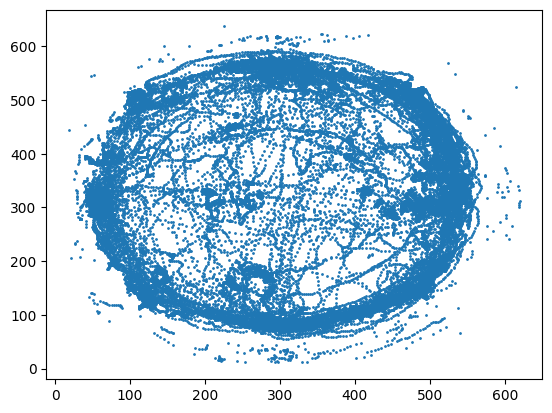

In [11]:
plt.scatter(df.head_x,df.head_y,s=1)

In [12]:
obj = project_large.object_list[2]
cName = f"{obj}_x"
print("Number of Nan for:",obj, np.sum(np.isnan(df[cName])))
print("percentage of Nan: {:.2f}%".format(np.sum(np.isnan(df[cName]))/len(df[cName])*100))

Number of Nan for: head 1501
percentage of Nan: 2.62%
